In [11]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal
from scipy.constants import c
from astropy.time import Time

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['font.size'] = 14

In [2]:
fs = 200
freq_correction_tx = 13527500/8388593
gnuradio_correction = 1.6
f_sep = 245e3 + gnuradio_correction + freq_correction_tx
freq_correction_rx = 31/2**32 * f_sep
correction_remaining = freq_correction_tx + freq_correction_rx - gnuradio_correction

In [3]:
def open_file(filename, skip=0):
    data = {}
    x = np.fromfile(filename,
                'float32').reshape(-1, 2).astype('float64')
    data['f_offset'] = float(filename[:-len('.f32x2')].split('_')[-1])
    t0 = np.datetime64(filename.split('_')[2])
    data['t'] = t0 + (np.arange(x.shape[0]) / fs * 1e9) * np.timedelta64(1, 'ns')
    data['bpsk_phase'] = np.unwrap(x[:, 1])/(2*np.pi)
    # apply frequency correction to diff_phase
    data['diff_phase'] = np.unwrap(x[:, 0])/(2*np.pi) - correction_remaining * np.arange(x.shape[0]) / fs
    data['t'] = data['t'][skip:]
    data['bpsk_phase'] = data['bpsk_phase'][skip:]
    data['diff_phase'] = data['diff_phase'][skip:]
    return data

def range_km(data):
    return -1e-3 * data['diff_phase'][::fs] / f_sep * c

T_range_delta = 100
def range_delta(data):
    return np.diff(range_km(data)[::T_range_delta]) * 1e3 / T_range_delta

def remove_average(x):
    return x - np.average(x)

In [5]:
filenames = [
    ('beacons_phases_2022-07-30T17:54:23.548821_tune_-130.f32x2', 100 * fs),
    ('beacons_phases_2022-08-01T03:35:30.274207_tune_-130.f32x2', 1800 * fs)] # there was a GPSDO restart here
#filenames = [
#    ('beacons_phases_2022-08-04T12:13:03.478121_tune_-130.f32x2', 100 * fs),
#    ('beacons_phases_2022-08-04T13:19:13.703807_tune_-130.f32x2', 100 * fs),
#    ('beacons_phases_2022-08-04T14:28:25.904339_tune_-130.f32x2', 100 * fs),
#    ('beacons_phases_2022-08-04T14:48:49.925560_tune_-130.f32x2', 300 * fs),
#     ('beacons_phases_2022-08-05T12:26:43.676045_tune_-130.f32x2', 100 * fs),
#    ('beacons_phases_2022-08-05T12:51:45.962058_tune_-130.f32x2', 100 * fs),
#]
data = [open_file(filename, skip) for filename, skip in filenames]

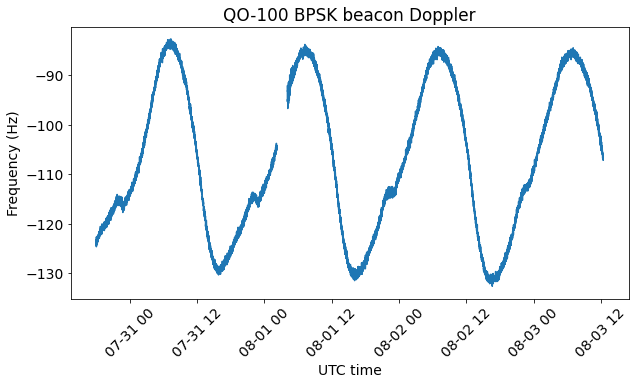

In [6]:
T_freq = 10
for d in data:
    f_doppler = np.diff(d['bpsk_phase'][::T_freq*fs])/T_freq + d['f_offset']
    plt.plot(d['t'][::T_freq*fs][:-1], f_doppler, color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Frequency (Hz)')
plt.title('QO-100 BPSK beacon Doppler');

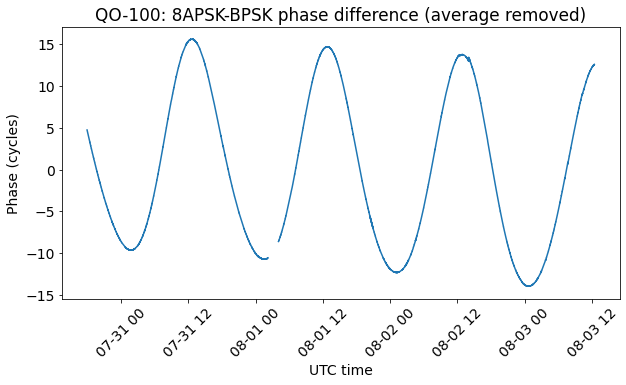

In [7]:
for d in data:
    plt.plot(d['t'][::fs], remove_average(d['diff_phase'][::fs]),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Phase (cycles)')
plt.title('QO-100: 8APSK-BPSK phase difference (average removed)');

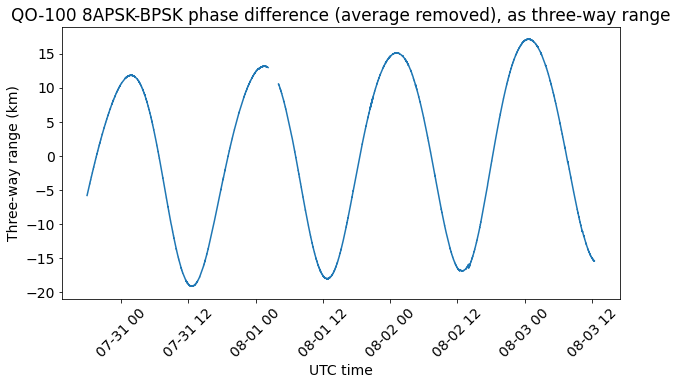

In [8]:
for d in data:
    plt.plot(d['t'][::fs], remove_average(range_km(d)), color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range (km)')
plt.title('QO-100 8APSK-BPSK phase difference (average removed), as three-way range');

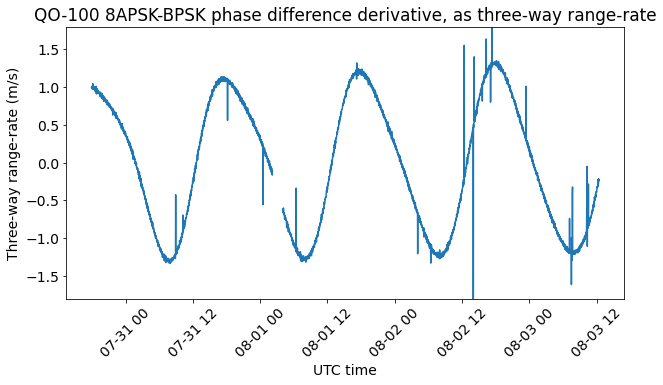

In [12]:
for d in data:
    plt.plot(d['t'][::fs*T_range_delta][:-1], range_delta(d),
             color='C0')
plt.xticks(rotation=45)
plt.xlabel('UTC time')
plt.ylabel('Three-way range-rate (m/s)')
plt.title('QO-100 8APSK-BPSK phase difference derivative, as three-way range-rate')
plt.ylim((-1.8, 1.8));

In [13]:
# Write GMD file for GMAT

with open('/tmp/qo100.gmd', 'w') as gmd:
    for d in data:
        for t, rr in zip(d['t'][::fs*T_range_delta][:-1], range_delta(d)):
            t = t + T_range_delta  # adjust timestamp to end of interval
            rr = rr * 1e-3  # convert from m/s to km/s
            tai_mjd = Time(t).tai.jd - 2430000.0
            print(f'{tai_mjd}\tRangeRate\t9010\t{{ 90001 43700 90002 }}\t1\t{T_range_delta}\t{rr}',
                  file=gmd)

In [9]:
stop

NameError: name 'stop' is not defined

## Glitches

In [ ]:
def plot_glitch(data, start, end):
    sel_glitch = (data['t'] >= np.datetime64(start)) & (data['t'] <= np.datetime64(end))
    plt.xticks(rotation=45)
    plt.plot(data['t'][sel_glitch], scipy.signal.detrend(data['bpsk_phase'][sel_glitch]))
    plt.ylabel('BPSK phase, detrended (cycles)', color='C0')
    plt.xlabel('UTC time')
    ax2 = plt.twinx()
    ax2.plot(data['t'][sel_glitch], scipy.signal.detrend(data['diff_phase'][sel_glitch]),
             color='C1')
    ax2.set_ylabel('8APSK-BPSK phase difference, detrended (cycles)', color='C1')
    plt.title('Phase glitch')

In [ ]:
plot_glitch(data[0], '2022-07-31T08:56:30', '2022-07-31T08:58')

In [ ]:
plot_glitch(data[0], '2022-07-31T08:57:12', '2022-07-31T08:57:18')

In [ ]:
plot_glitch(data[0], '2022-07-31T10:13', '2022-07-31T10:14:30')

In [ ]:
plot_glitch(data[0], '2022-07-31T10:13:44', '2022-07-31T10:13:50')

In [ ]:
plot_glitch(data[0], '2022-07-31T18:11', '2022-07-31T18:12:30')

In [ ]:
plot_glitch(data[0], '2022-07-31T18:11:48', '2022-07-31T18:11:54')

In [ ]:
plot_glitch(data[0], '2022-08-01T00:31:15', '2022-08-01T00:32:45')

In [ ]:
plot_glitch(data[0], '2022-08-01T00:31:49', '2022-08-01T00:31:55')

In [ ]:
plot_glitch(data[1], '2022-08-01T06:24:45', '2022-08-01T06:26:15')

In [ ]:
plot_glitch(data[1], '2022-08-01T06:25:27', '2022-08-01T06:25:33')